In [14]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, Activation, Reshape, MaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import RMSprop
from keras import backend as K
from keras.layers.convolutional import Conv1D, Conv2D
from keras import optimizers
import sys
import keras.utils
import os
sys.path.append(os.path.join(sys.path[0], '../utils'))
from load_mat_file import load_mat_file, show_data, show_sample, load_all_data_multichannel 
from keras.callbacks import TensorBoard
import copy
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#, RobustScaler

from sklearn.datasets import fetch_california_housing

In [15]:
data_path = '/workspace/data/eeg/'

In [16]:
def create_network(input_dim, num_classes):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(128, input_shape=(input_dim,)))
    seq.add(Activation('relu'));
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(num_classes, activation='relu'))
    model.add(Activation('softmax'))
    return seq


def create_network_tu(max_words, num_classes):
    model = Sequential()
    model.add(Dense(512, input_shape=(max_words,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model;


def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()


def create_network_eeg_conv1(input_dim, num_classes):
    seq = Sequential()
    seq.add(Reshape(( input_dim, 1,), input_shape=(input_dim,)))
    seq.add(Conv1D(filters=16, kernel_size=5, activation='relu', strides=2))
    seq.add(MaxPooling1D(3, strides=2))
    seq.add(Conv1D(32, 5, activation='relu'))
    seq.add(MaxPooling1D(3, strides=2))
    seq.add(Conv1D(32, 3, activation='relu'))
    seq.add(MaxPooling1D(3, strides=2))
    seq.add(Conv1D(32, 3, activation='relu'))
    seq.add(MaxPooling1D(3, strides=2))
    seq.add(GlobalAveragePooling1D())
    #seq.add(Reshape(11328,1))
    seq.add(Dense(units=128))
    seq.add(Activation('relu'));
    seq.add(Dense(units=num_classes))
    #seq.add(Reshape((num_classes,)))
    seq.add(Activation('softmax'));
    return seq;

def create_network_eeg_conv1_multichannel(input_dim, num_channels, num_classes):
    seq = Sequential()
    #seq.add(Reshape(( input_dim, 1,), input_shape=(input_dim,)))
    seq.add(Conv1D(filters=64, kernel_size=5, activation='relu', strides=2, input_shape=(input_dim,num_channels,)))
    seq.add(MaxPooling1D(3, strides=2))
    seq.add(Conv1D(32, 5, activation='relu'))
    seq.add(MaxPooling1D(3, strides=2))
    seq.add(Conv1D(32, 3, activation='relu'))
    seq.add(MaxPooling1D(3, strides=2))
    seq.add(Conv1D(32, 3, activation='relu'))
    seq.add(MaxPooling1D(3, strides=2))
    seq.add(GlobalAveragePooling1D())
    #seq.add(Reshape(11328,1))
    seq.add(Dense(units=128))
    seq.add(Activation('relu'));
    seq.add(Dense(units=num_classes))
    #seq.add(Reshape((num_classes,)))
    seq.add(Activation('softmax'));
    return seq;

In [17]:
def create_cnn_mc_small(input_dim, num_channels, num_classes):
    seq = Sequential()
    #seq.add(Reshape(( input_dim, 1,), input_shape=(input_dim,)))
    seq.add(Conv1D(filters=64, kernel_size=5, activation='elu', strides=2, input_shape=(input_dim,num_channels,)))
    seq.add(MaxPooling1D(3, strides=2))
    seq.add(Conv1D(32, 5, activation='elu'))
    seq.add(MaxPooling1D(3, strides=2))
    #seq.add(Conv1D(32, 3, activation='relu'))
    #seq.add(MaxPooling1D(3, strides=2))
    #seq.add(Conv1D(32, 3, activation='relu'))
    #seq.add(MaxPooling1D(3, strides=2))
    print (seq.output_shape)
    #seq.add(Reshape( (1,seq.output_shape[1]*seq.output_shape[2]) ))
    seq.add(GlobalAveragePooling1D())
    #seq.add(Reshape(11328,1))
    seq.add(Dense(units=32))
    seq.add(Activation('elu'));
    seq.add(Dense(units=num_classes))
    #seq.add(Reshape((num_classes,)))
    seq.add(Activation('softmax'));
    return seq;

#model = create_cnn_mc_small(size_of_sample, number_of_channels, num_classes)
#model = create_network_eeg_conv1_multichannel(size_of_sample, number_of_channels, num_classes)
#print(model.summary())


In [18]:
def normalize_data(X_data):
    scaler = StandardScaler().fit(X_data)
    #scaler = RobustScaler.fit(X_data)
    #scaler = MinMaxScaler().fit(X_data)
    X_data_norm = scaler.transform(X_data)
    return X_data_norm
    #max_n = np.max(X_data[:,:,indx])
    #min_n = np.min(X_data[:,:,indx])
    #meanX = np.mean(X_data, axis=0)
    #X_data_norm = np.zeros(X_data.shape)
    #X_data_norm[i,:,:] = np.subtract(X_data[i,:,:], meanX);
    #for i in range(X_data.shape[0]):
    #   X_data_norm[i,:,:] = np.subtract(X_data[i,:,:], meanX);
    #show_sample(meanX, [0])
    #show_sample(scaler.mean_, [0])
    #X_data_norm = scaler.transform(X_data)
    #show_data(X_data, Y_data, 1, [0])
    #show_data(X_data_norm, Y_data, 1, [0])
    
#X_data_norm = normalize_data(X_data);
#print('before')
#print('min ', np.min(X_data), '; max ', np.max(X_data))
#print('after')
#print('min ', np.min(X_data_norm), '; max ', np.max(X_data_norm))
#show_data(X_data, Y_data, 1, [0])
#show_data(X_data_norm, Y_data, 1, [0])

In [19]:
X_data, Y_data = load_all_data_multichannel(data_path);
number_of_samples = X_data.shape[0];
size_of_sample = X_data.shape[1];
number_of_channels = X_data.shape[2];

print('number of samples:', number_of_samples)
print('time counts:', size_of_sample)
print('number_of_channels:', number_of_channels)
print('min ', np.min(X_data), '; max ', np.max(X_data))
Y_data = Y_data - 1;
Y_data = Y_data.reshape(Y_data.shape[0])
num_classes = int(max(Y_data) + 1);
print('num_classes: ', num_classes)
y_= keras.utils.to_categorical(Y_data, int(num_classes));
#show_data(X_data, Y_data, 1, [0,1])

number of samples: 3703
time counts: 275
number_of_channels: 4
min  -84.92 ; max  68.29
num_classes:  2


In [20]:
x_= X_data;
test_prop = 0.1;
test_size= round(test_prop * number_of_samples, 0);
test_size = int(test_size)
train_size = number_of_samples - test_size;

train size:  3333
test size:  370
shuffled data 
original data 


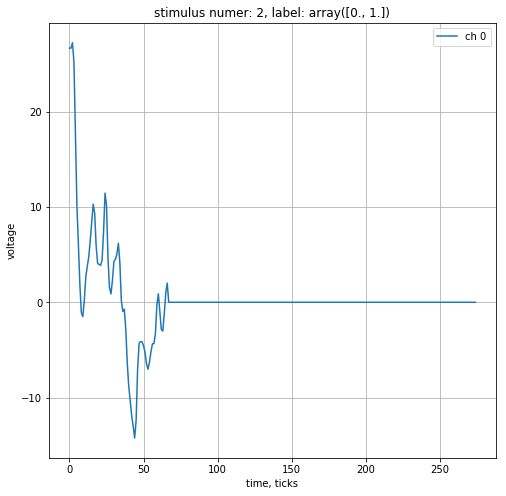

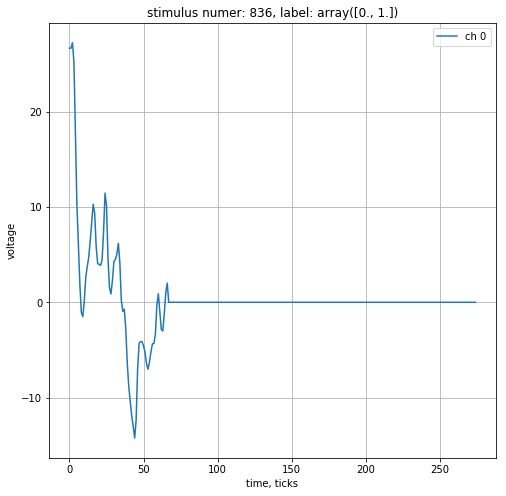

In [26]:
#random shuffle of dataset and train-test split
idx = np.random.choice(np.arange(x_.shape[0]), x_.shape[0], replace=False)
idx_train = idx[0:train_size]
idx_test = idx[train_size:]
print('train size: ', train_size)
print('test size: ', test_size)
y_train = y_[idx_train];
x_train = x_[idx_train];
y_test= y_[idx_test];
x_test= x_[idx_test];

#check we don't spoiled labels
print('shuffled data ')
show_data(x_train, y_train, 2, [0])
print('original data ')
show_data(x_, y_, idx_train[2], [0])

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [23]:
#model = create_cnn_mc_small(size_of_sample, number_of_channels, num_classes)
model = create_network_eeg_conv1_multichannel(size_of_sample, number_of_channels, num_classes)
print(model.summary())
#model = create_network_tu(size_of_sample, num_classes)
#print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 136, 64)           1344      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 67, 64)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 63, 32)            10272     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 31, 32)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 29, 32)            3104      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 14, 32)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 12, 32)            3104      
__________

/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

In [25]:
batch_size = 10;
epochs = 20;
sgd = optimizers.Adagrad(lr=0.0001, decay=0)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[tensorboard])

score = model.evaluate(x_test, y_test, batch_size=batch_size)
print(score)

/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Train on 2666 samples, validate on 667 samples
Epoch 1/20
2666/2666 [==============================] - 2s 868us/step - loss: 0.6931 - acc: 0.5101 - val_loss: 0.6953 - val_acc: 0.4633
Epoch 2/20
2666/2666 [==============================] - 2s 834us/step - loss: 0.6929 - acc: 0.5109 - val_loss: 0.6951 - val_acc: 0.4648
Epoch 3/20
2666/2666 [==============================] - 2s 833us/step - loss: 0.6928 - acc: 0.5143 - val_loss: 0.6950 - val_acc: 0.4663
Epoch 4/20
2666/2666 [==============================] - 2s 836us/step - loss: 0.6928 - acc: 0.5150 - val_loss: 0.6949 - val_acc: 0.4648
Epoch 5/20
2666/2666 [==============================] - 2s 842us/step - loss: 0.6927 - acc: 0.5135 - val_loss: 0.6949 - val_acc: 0.4618
Epoch 6/20
2666/2666 [==============================] - 2s 834us/step - loss: 0.6927 - acc: 0.5154 - val_loss: 0.6948 - val_acc: 0.4588
Epoch 7/20
2666/2666 [==============================] - 2s 839us/step - loss: 0.6927 - acc: 0.5161 - val_loss: 0.6948 - val_acc: 0.4573
E

KeyboardInterrupt: 